# Vettore COVID

Analisi tridimensionale dei dati COVID-19

> Max Pierini

***

I dati giornalieri di

- nuovi positivi
- nuovi deceduti
- occupazione terapie intensive

di COVID-19 in Italia (da Dipartimento di Protezione Civile) da cui è stato ricavato il trend per decomposizione stagionale per smussare le variazioni settimanali (vedi [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) per dettagli) sono stati utilizzati come coordinate in uno spazio tridimensionale

\begin{equation}
\begin{bmatrix}
x(t) \\ y(t) \\ z(t)
\end{bmatrix}
=
\begin{bmatrix}
\textrm{nuovi positivi} \\
\textrm{terapia intensiva} \\
\textrm{nuovi deceduti}
\end{bmatrix}
\end{equation}

e normalizzati

\begin{equation}
\begin{bmatrix}
X(t) \\ Y(t) \\ Z(t)
\end{bmatrix}
=
\begin{bmatrix}
x(t) \cdot \max(x)^{-1} \\ y(t) \cdot \max(y)^{-1} \\ z(t) \cdot \max(z)^{-1}
\end{bmatrix}
\end{equation}

anche in forma logaritmica

\begin{equation}
\begin{bmatrix}
\log{X}(t) \\ \log{Y}(t) \\ \log{Z}(t)
\end{bmatrix}
=
\begin{bmatrix}
\log{x(t)} \cdot \max(\log{x})^{-1} \\ 
\log{y(t)} \cdot \max(\log{y})^{-1} \\ 
\log{z(t)} \cdot \max(\log{z})^{-1}
\end{bmatrix}
\end{equation}

Dai dati dell'ultimo giorno $t=\tau$, è calcolato il modulo del vettori $\mathbf{v}_{raw}$ dei dati grezzi normalizzati e $\mathbf{v}_{\log}$ dei dati logaritmici normalizzati

\begin{equation}
|\mathbf{v}_{raw}| = \sqrt{X(\tau)^2 + Y(\tau)^2 + Z(\tau)^2}
\end{equation}

e

\begin{equation}
|\mathbf{v}_{\log}| = \sqrt{\log X(\tau)^2 + \log Y(\tau)^2 +  \log Z(\tau)^2}
\end{equation}

In entrambi i casi, il modulo massimo $\max(|\mathbf{v}|)$ che il vettore può assumere è

\begin{equation}
\max(|\mathbf{v}|) = \sqrt{1^2 + 1^2 + 1^2} = \sqrt{3}
\end{equation}

e il volume massimo del cuboide con vertice [1,1,1]' è

\begin{equation}
\max(\mathbf{V}) = 1 \cdot 1 \cdot 1 = 1
\end{equation}

da cui vengono calcolate le percentuali $p(\mathbf{v}_{raw})$ e $p(\mathbf{v}_{\log})$

\begin{equation}
p(\mathbf{v}_{raw}) = 
\frac{|\mathbf{v}_{raw}|}{\max(|\mathbf{v}|)} =
\frac{|\mathbf{v}_{raw}|}{\sqrt{3}}
\end{equation}

\begin{equation}
p(\mathbf{v}_{\log}) = 
\frac{|\mathbf{v}_{\log}|}{\max(|\mathbf{v}|)} =
\frac{|\mathbf{v}_{\log}|}{\sqrt{3}}
\end{equation}

e i volumi

\begin{equation}
\mathbf{V}_{raw} = X(\tau) \cdot Y(\tau) \cdot Z(\tau)
\end{equation}

\begin{equation}
\mathbf{V}_{\log} = \log X(\tau) \cdot \log Y(\tau) \cdot \log Z(\tau)
\end{equation}

che saranno pari a 1 (100%) se il valore attuale è il massimo osservabile e pari a 0 in caso di completa risoluzione dell'evento pandemico.

Valori intermedi, saranno una stima della situazione attuale. In particolare

- $p(\mathbf{v}_{raw})$ e $\mathbf{V}_{raw}$ sono una buona indicazione della condizione attuale rispetto al massimo osservato
- $p(\mathbf{v}_{\log})$ e $\mathbf{V}_{\log}$ sono una buona indicazione della condizione attuale rispetto alla completa risoluzione

Nella rappresentazione tridimensionale sui piani $XY$, $YZ$ e $XZ$ sono visibili le correlazioni bidimensionali dei dati normalizzati, suddivise per semestri.

> NOTA: la decomposizione stagionale, con periodo 7 giorni, comporta che mediamente 3.5 giorni siano nulli agli estremi della serie temporale. Pertanto il dato più aggiornato risale a **3 giorni fa**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d

from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import Markdown

In [2]:
# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [3]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/'
    'dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)
df.index = df.index.normalize()

In [4]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [5]:
df.loc[df.index[0], 'nuovi_deceduti'] = df.deceduti.values[0]

In [6]:
def plot_fig(X, Y, Z, W, ax, legend=True):
    # x-axis
    aX = Arrow3D([0, 1], [0, 0], [0, 0],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aX)
    # y-axis
    aY = Arrow3D([0, 0], [0, 1], [0, 0],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aY)
    # z-axis
    aZ = Arrow3D([0, 0], [0, 0], [0, 1],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aZ)

    ax.set(
        xlabel='nuovi positivi',
        ylabel='terapia intensiva',
        zlabel='nuovi deceduti',
        xlim=(0, 1),
        ylim=(0, 1),
        zlim=(0, 1),
    )


    ax.view_init(90/6, 90/3)
    
    df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'W':W})
    for i, W in enumerate(df.W.unique()):
        _df = df[df.W==W]
        _X = _df.X.values
        _Y = _df.Y.values
        _Z = _df.Z.values
        #ax.scatter(_X, _Y, _Z, label=W if legend else None, s=50, zorder=1)
        ax.plot(_X, _Y, 0, zdir='z', lw=1, color=f'C{i}', ms=7,
                label=W if legend else None,
                zorder=0, alpha=.75, marker='.')
        ax.plot(_X, _Z, 0, zdir='y', lw=1, color=f'C{i}', ms=7,
                zorder=0, alpha=.75, marker='.')
        ax.plot(_Y, _Z, 0, zdir='x', lw=1, color=f'C{i}', ms=7,
                zorder=0, alpha=.75, marker='.')


    ax.plot(
        [0, X[-1]],
        [0, Y[-1]],
        [0, Z[-1]],
        lw=3, color='k',
        label='oggi' if legend else None
    )

    # star
    #ax.plot(X[-1], Y[-1], Z[-1], marker='.', color='k', ms=5, ls='none', zorder=10, alpha=1)
    # plane projections
    ax.plot(X[-1], Y[-1], 0, zdir='z', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    ax.plot(X[-1], Z[-1], 0, zdir='y', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    ax.plot(Y[-1], Z[-1], 0, zdir='x', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    # projection lines
    ax.plot([X[-1], X[-1]], [Y[-1], Y[-1]], [0, Z[-1]], color='k', ls='--', lw=1, zorder=10, alpha=1)
    ax.plot([X[-1], X[-1]], [0, Y[-1]], [Z[-1], Z[-1]], color='k', ls='--', lw=1, zorder=10, alpha=1)
    ax.plot([0, X[-1]], [Y[-1], Y[-1]], [Z[-1], Z[-1]], color='k', ls='--', lw=1, zorder=10, alpha=1)

    rectXY = patches.Rectangle((0, 0), X[-1], Y[-1], facecolor='grey', alpha=.35)
    ax.add_patch(rectXY)
    art3d.pathpatch_2d_to_3d(rectXY, z=0, zdir="z")

    rectXZ = patches.Rectangle((0, 0), X[-1], Z[-1], facecolor='grey', alpha=.25)
    ax.add_patch(rectXZ)
    art3d.pathpatch_2d_to_3d(rectXZ, z=0, zdir="y")

    rectYZ = patches.Rectangle((0, 0), Y[-1], Z[-1], facecolor='grey', alpha=.20)
    ax.add_patch(rectYZ)
    art3d.pathpatch_2d_to_3d(rectYZ, z=0, zdir="x")
    
    MAX = np.sqrt(3)
    mod = np.sqrt(X[-1]**2 + Y[-1]**2 + Z[-1]**2)
    
    vol = X[-1] * Y[-1] * Z[-1]

    ax.set_title(f"modulo: {mod/MAX:.1%} - volume: {vol:.1%}", fontsize=20, y=.925)

In [7]:
def plot_single_fig(X, Y, Z, W, 
                    x, y, z, w, data,
                    title,
                    ax, legend=True):
    # x-axis
    aX = Arrow3D([0, 1], [0, 0], [0, 0],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aX)
    # y-axis
    aY = Arrow3D([0, 0], [0, 1], [0, 0],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aY)
    # z-axis
    aZ = Arrow3D([0, 0], [0, 0], [0, 1],
                 mutation_scale=15, 
                 lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(aZ)

    ax.set(
        xlabel='nuovi positivi',
        ylabel='terapia intensiva',
        zlabel='nuovi deceduti',
        xlim=(0, 1),
        ylim=(0, 1),
        zlim=(0, 1),
    )


    ax.view_init(90/6, 90/3)
    
    df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'W':W})
    for i, W in enumerate(df.W.unique()):
        _df = df[df.W==W]
        _X = _df.X.values
        _Y = _df.Y.values
        _Z = _df.Z.values
        #ax.scatter(_X, _Y, _Z, label=W if legend else None, s=50, zorder=1)
        ax.plot(_X, _Y, 0, zdir='z', lw=1, color=f'C{i}', ms=7,
                label=W if legend else None,
                zorder=0, alpha=.75, marker='.')
        ax.plot(_X, _Z, 0, zdir='y', lw=1, color=f'C{i}', ms=7,
                zorder=0, alpha=.75, marker='.')
        ax.plot(_Y, _Z, 0, zdir='x', lw=1, color=f'C{i}', ms=7,
                zorder=0, alpha=.75, marker='.')


    ax.plot(
        [0, x],
        [0, y],
        [0, z],
        lw=3, color='k',
        #label='oggi' if legend else None
    )

    # star
    #ax.plot(X, Y, Z, marker='.', color='k', ms=5, ls='none', zorder=10, alpha=1)
    # plane projections
    ax.plot(x, y, 0, zdir='z', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    ax.plot(x, z, 0, zdir='y', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    ax.plot(y, z, 0, zdir='x', marker='.', color='k', ms=3, ls='none', zorder=10, alpha=.25)
    # projection lines
    ax.plot([x, x], [y, y], [0, z], color='k', ls='--', lw=1, zorder=10, alpha=1)
    ax.plot([x, x], [0, y], [z, z], color='k', ls='--', lw=1, zorder=10, alpha=1)
    ax.plot([0, x], [y, y], [z, z], color='k', ls='--', lw=1, zorder=10, alpha=1)

    rectXY = patches.Rectangle((0, 0), x, y, facecolor='grey', alpha=.35)
    ax.add_patch(rectXY)
    art3d.pathpatch_2d_to_3d(rectXY, z=0, zdir="z")

    rectXZ = patches.Rectangle((0, 0), x, z, facecolor='grey', alpha=.25)
    ax.add_patch(rectXZ)
    art3d.pathpatch_2d_to_3d(rectXZ, z=0, zdir="y")

    rectYZ = patches.Rectangle((0, 0), y, z, facecolor='grey', alpha=.20)
    ax.add_patch(rectYZ)
    art3d.pathpatch_2d_to_3d(rectYZ, z=0, zdir="x")
    
    MAX = np.sqrt(3)
    mod = np.sqrt(x**2 + y**2 + z**2)
    
    vol = x * y * z

    ax.set_title(
        f"{title}\n"
        f"{data.strftime('%d %B %Y')}\n"
        f"modulo: {mod/MAX:.1%} - volume: {vol:.1%}", 
        fontsize=20, y=.925)

In [8]:
def plot_norm_cube(df, 
                   x='nuovi_positivi', 
                   y='terapia_intensiva', 
                   z='nuovi_deceduti'):
    
    for col in [x, y, z]:
        df.loc[df[col]<0, col] = np.nan
        df.loc[df[col]==0, col] = 1
    df.fillna(method='ffill', inplace=True)
    
    _df = pd.DataFrame(seasonal_decompose(df['nuovi_positivi'], period=7).trend.dropna())
    
    # ===================== prepare
    _df.loc[_df.index<'2020-07-01', 'W'] = '2020 Gen-Giu'
    _df.loc[(_df.index>='2020-07-01')&(_df.index<'2021-01-01'), 'W'] = '2020 Lug-Dic'
    _df.loc[_df.index>='2021-01-01', 'W'] = '2021 Gen-oggi'
    W = _df.W.values
    index = _df.index
    
    _X_ = seasonal_decompose(df[x], period=7).trend.dropna().values
    X = _X_ / _X_.max()
    _Xl_ = np.log(_X_)
    Xl = _Xl_ / _Xl_.max()
    
    _Y_ = seasonal_decompose(df[y], period=7).trend.dropna().values
    Y = _Y_ / _Y_.max()
    _Yl_ = np.log(_Y_)
    Yl = _Yl_ / _Yl_.max()
    
    _Z_ = seasonal_decompose(df[z], period=7).trend.dropna().values
    Z = _Z_ / _Z_.max()
    _Zl_ = np.log(_Z_)
    Zl = _Zl_ / _Zl_.max()

    
    # ===================== plot
    
    # ===================== raw normalized
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(projection='3d')
    plot_fig(X, Y, Z, W, ax1)
    fig.suptitle(
        f'Vettore COVID-19 Italia, aggiornato al {_df.index[-1].date()}\n'
        'normalizzato grezzo',
        y=.85, fontsize=20
    )
    fig.legend(
        loc='lower center', bbox_to_anchor=(.5, .15),
        ncol=_df.W.unique().size + 1
    )
    plt.show()

    # ===================== log normalized
    fig = plt.figure(figsize=(12, 12))
    ax2 = fig.add_subplot(projection='3d')
    plot_fig(Xl, Yl, Zl, W, ax2)
    fig.suptitle(
        f'Vettore COVID-19 Italia, aggiornato al {_df.index[-1].date()}\n'
        'normalizzato logaritmico',
        y=.85, fontsize=20
    )
    fig.legend(
        loc='lower center', bbox_to_anchor=(.5, .15),
        ncol=_df.W.unique().size + 1
    )
    plt.show()


In [9]:
def plot_min_max_cube(df, 
                   x='nuovi_positivi', 
                   y='terapia_intensiva', 
                   z='nuovi_deceduti'):
    
    for col in [x, y, z]:
        df.loc[df[col]<0, col] = np.nan
        df.loc[df[col]==0, col] = 1
    df.fillna(method='ffill', inplace=True)
    
    _df = pd.DataFrame(seasonal_decompose(df['nuovi_positivi'], period=7).trend.dropna())
    
    # ===================== prepare
    _df.loc[_df.index<'2020-07-01', 'W'] = '2020 Gen-Giu'
    _df.loc[(_df.index>='2020-07-01')&(_df.index<'2021-01-01'), 'W'] = '2020 Lug-Dic'
    _df.loc[_df.index>='2021-01-01', 'W'] = '2021 Gen-oggi'
    W = _df.W.values
    index = _df.index
    
    _X_ = seasonal_decompose(df[x], period=7).trend.dropna().values
    X = _X_ / _X_.max()
    _Xl_ = np.log(_X_)
    Xl = _Xl_ / _Xl_.max()
    
    _Y_ = seasonal_decompose(df[y], period=7).trend.dropna().values
    Y = _Y_ / _Y_.max()
    _Yl_ = np.log(_Y_)
    Yl = _Yl_ / _Yl_.max()
    
    _Z_ = seasonal_decompose(df[z], period=7).trend.dropna().values
    Z = _Z_ / _Z_.max()
    _Zl_ = np.log(_Z_)
    Zl = _Zl_ / _Zl_.max()
    
    DF = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z, 'W':W, 'data':index})
    DF['modulo'] = np.sqrt(DF.X**2 + DF.Y**2 + DF.Z**2)
    DF['Modulo'] = DF['modulo'] / np.sqrt(3)
    DF['volume'] = DF.X * DF.Y * DF.Z
    mod_max = DF[DF.modulo==DF.modulo.max()]
    vol_max = DF[DF.volume==DF.volume.max()]
    mod_min = DF[DF.modulo==DF.modulo.min()]
    vol_min = DF[DF.volume==DF.volume.min()]
    
    DFl = pd.DataFrame({'X':Xl, 'Y':Yl, 'Z':Zl, 'W':W, 'data':index})
    DFl['modulo'] = np.sqrt(DFl.X**2 + DFl.Y**2 + DFl.Z**2)
    DFl['Modulo'] = DFl['modulo'] / np.sqrt(3)
    DFl['volume'] = DFl.X * DFl.Y * DFl.Z
    mod_maxl = DFl[DFl.modulo==DFl.modulo.max()]
    vol_maxl = DFl[DFl.volume==DFl.volume.max()]
    mod_minl = DFl[DFl.modulo==DFl.modulo.min()]
    vol_minl = DFl[DFl.volume==DFl.volume.min()]
    
    # ===================== plot
    
    display(Markdown("# Serie temporali"))
    fig, ax = plt.subplots(figsize=(15, 5))
    DF.plot(ax=ax, x='data', y='Modulo', color='C0')
    ax.set(
        ylim=(0, 1), ylabel='modulo',
        title='Modulo e Volume vettore COVID (normalizzati grezzi)'
    )
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
    axA = ax.twinx()
    DF.plot(ax=axA, x='data', y='volume', color='C1')
    axA.set(
        ylim=(0, 1), ylabel='volume'
    )
    axA.legend(loc='lower right', bbox_to_anchor=(1, 1))
    plt.show()
    
    fig, ax = plt.subplots(figsize=(15, 5))
    DFl.plot(ax=ax, x='data', y='Modulo', color='C0')
    ax.set(
        ylim=(0, 1), ylabel='modulo',
        title='Modulo e Volume vettore COVID (normalizzati logaritmici)'
    )
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
    axA = ax.twinx()
    DFl.plot(ax=axA, x='data', y='volume', color='C1')
    axA.set(
        ylim=(0, 1), ylabel='volume'
    )
    axA.legend(loc='lower right', bbox_to_anchor=(1, 1))
    plt.show()
    
    # ===================== MAXIMA
    display(Markdown("# Massimi"))
    fig = plt.figure(figsize=(15, 15))
    
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    plot_single_fig(
        X, Y, Z, W,
        mod_max.X.values[0], 
        mod_max.Y.values[0], 
        mod_max.Z.values[0], 
        mod_max.W.values[0],
        mod_max.data.dt.date.values[0],
        'modulo normalizzato grezzo',
        ax1
    )
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    plot_single_fig(
        X, Y, Z, W,
        vol_max.X.values[0], 
        vol_max.Y.values[0], 
        vol_max.Z.values[0], 
        vol_max.W.values[0], 
        vol_max.data.dt.date.values[0],
        'volume normalizzato grezzo',
        ax2, legend=False
    )
    
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    plot_single_fig(
        Xl, Yl, Zl, W,
        mod_maxl.X.values[0], 
        mod_maxl.Y.values[0], 
        mod_maxl.Z.values[0], 
        mod_maxl.W.values[0], 
        mod_maxl.data.dt.date.values[0],
        'modulo normalizzato logaritmico',
        ax3, legend=False
    )
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    plot_single_fig(
        Xl, Yl, Zl, W,
        vol_maxl.X.values[0], 
        vol_maxl.Y.values[0], 
        vol_maxl.Z.values[0], 
        vol_maxl.W.values[0], 
        vol_maxl.data.dt.date.values[0],
        'volume normalizzato logaritmico',
        ax4, legend=False
    )
    fig.suptitle(
        f'Vettore COVID-19 Italia, massimi osservati',
        y=.95, fontsize=20
    )
    fig.legend(
        loc='upper center', bbox_to_anchor=(.5, .93),
        ncol=DF.W.unique().size
    )
    plt.show()
    
    # ===================== MINIMA
    display(Markdown("# Minimi"))
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    plot_single_fig(
        X, Y, Z, W,
        mod_min.X.values[0], 
        mod_min.Y.values[0], 
        mod_min.Z.values[0], 
        mod_min.W.values[0], 
        mod_min.data.dt.date.values[0],
        'modulo normalizzato grezzo',
        ax1
    )
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    plot_single_fig(
        X, Y, Z, W,
        vol_min.X.values[0], 
        vol_min.Y.values[0], 
        vol_min.Z.values[0], 
        vol_min.W.values[0], 
        vol_min.data.dt.date.values[0],
        'volume normalizzato grezzo',
        ax2, legend=False
    )
    
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    plot_single_fig(
        Xl, Yl, Zl, W,
        mod_minl.X.values[0], 
        mod_minl.Y.values[0], 
        mod_minl.Z.values[0], 
        mod_minl.W.values[0], 
        mod_minl.data.dt.date.values[0],
        'modulo normalizzato logaritmico',
        ax3, legend=False
    )
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    plot_single_fig(
        Xl, Yl, Zl, W,
        vol_minl.X.values[0], 
        vol_minl.Y.values[0], 
        vol_minl.Z.values[0], 
        vol_minl.W.values[0], 
        vol_minl.data.dt.date.values[0],
        'volume normalizzato logaritmico',
        ax4, legend=False
    )
    fig.suptitle(
        f'Vettore COVID-19 Italia, minimi osservati',
        y=.95, fontsize=20
    )
    fig.legend(
        loc='upper center', bbox_to_anchor=(.5, .93),
        ncol=DF.W.unique().size
    )
    plt.show()

# Situazione attuale

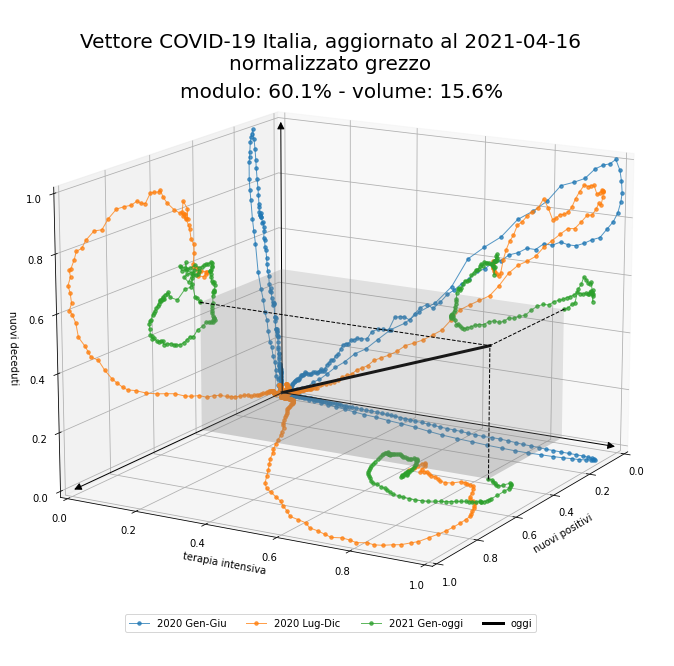

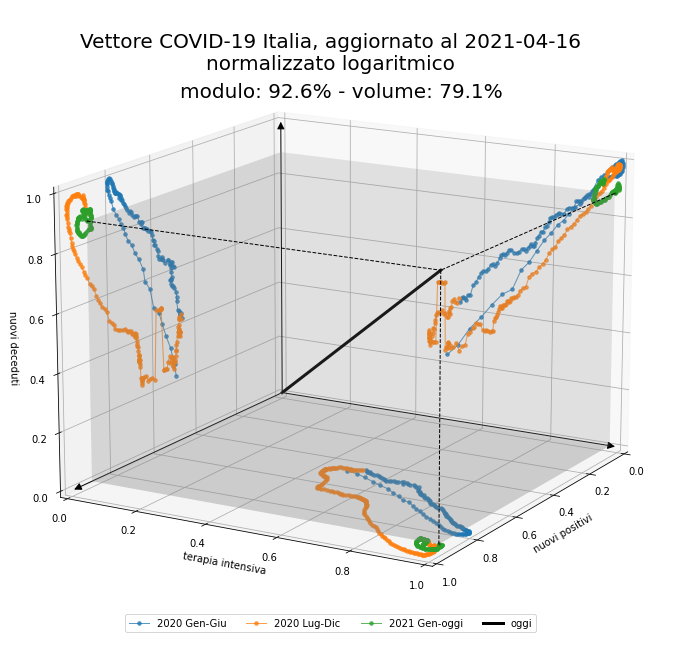

In [10]:
plot_norm_cube(df)

# Serie temporali

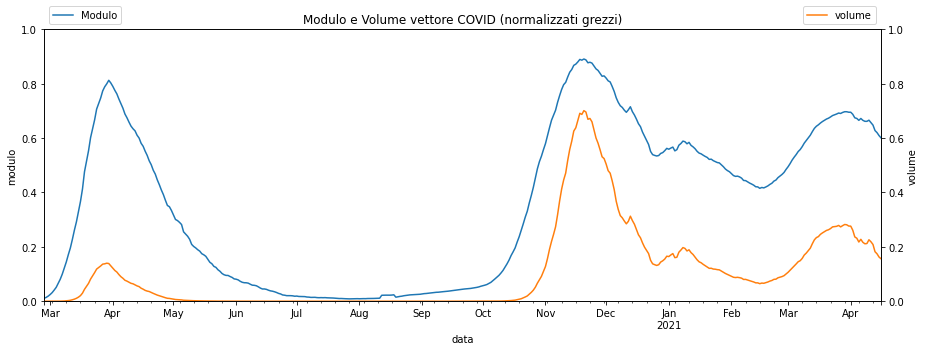

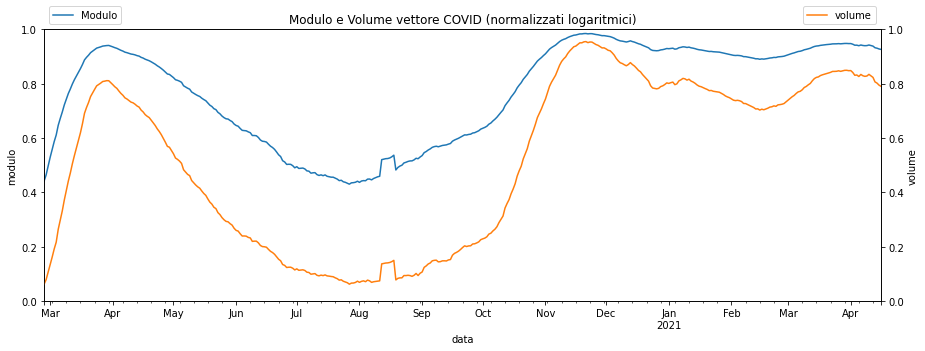

# Massimi

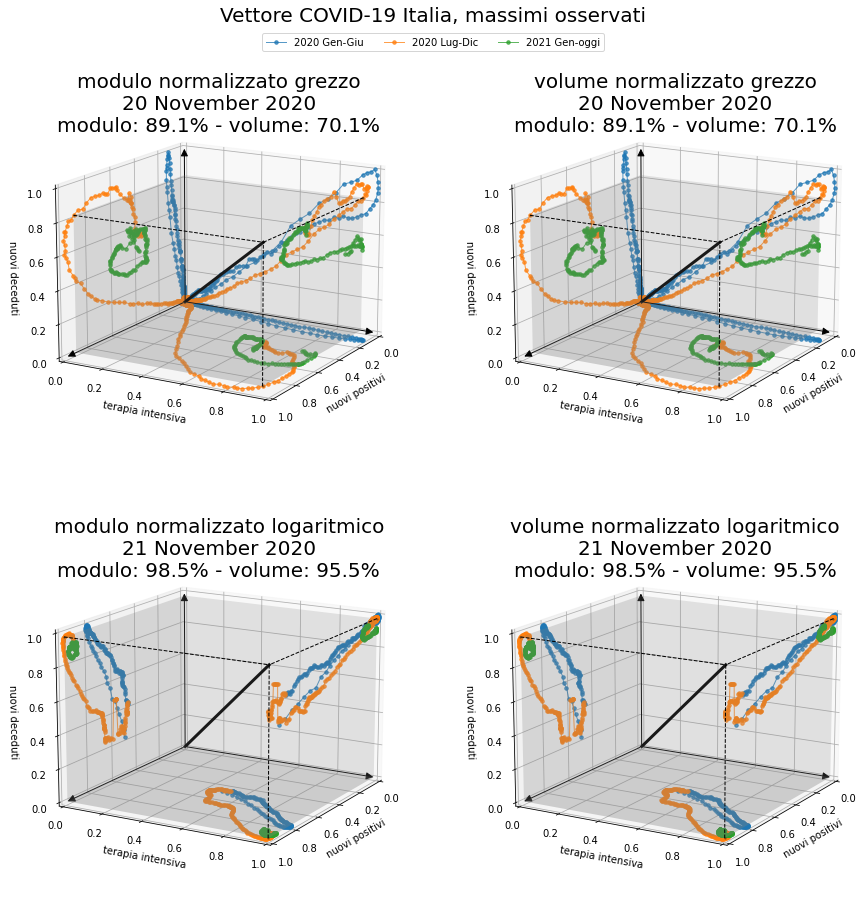

# Minimi

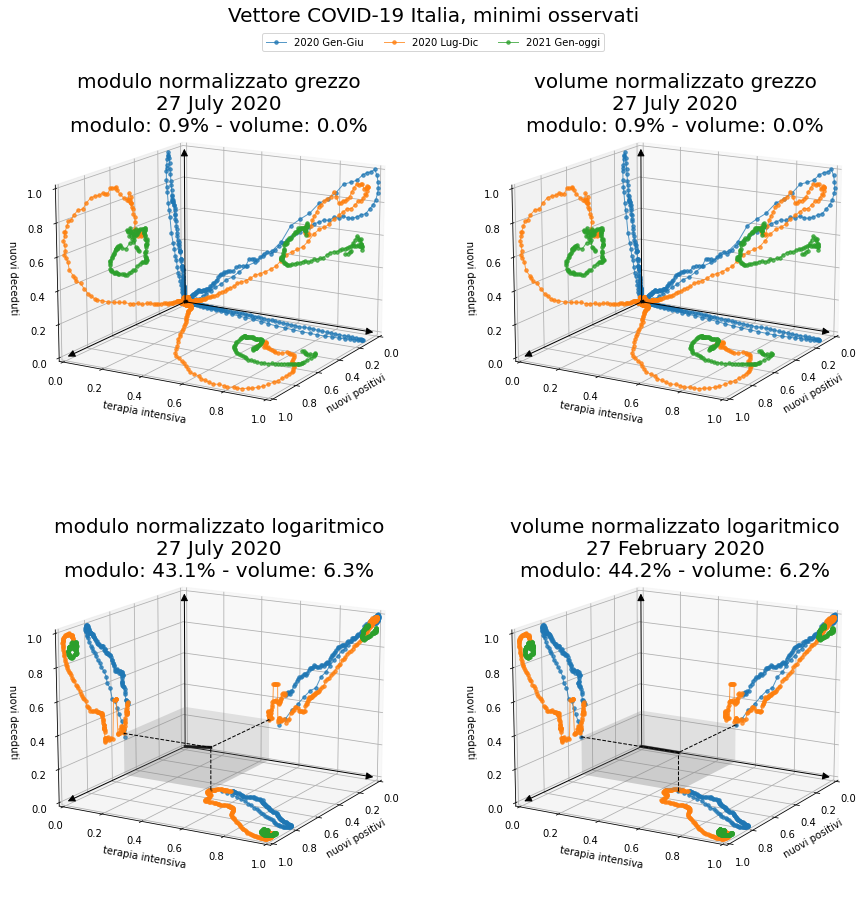

In [11]:
t = plot_min_max_cube(df)